In [1]:
# 查看当前挂载的数据集目录, 该目录下的变更重启环境后会自动还原
# View dataset directory. 
# This directory will be recovered automatically after resetting environment. 
!ls /home/aistudio/data

In [2]:
# 查看工作区文件, 该目录下的变更将会持久保存. 请及时清理不必要的文件, 避免加载过慢.
# View personal work directory. 
# All changes under this directory will be kept even after reset. 
# Please clean unnecessary files in time to speed up environment loading. 
!ls /home/aistudio/work

In [3]:
# 如果需要进行持久化安装, 需要使用持久化路径, 如下方代码示例:
# If a persistence installation is required, 
# you need to use the persistence path as the following: 
!mkdir /home/aistudio/external-libraries
!pip install beautifulsoup4 -t /home/aistudio/external-libraries

Looking in indexes: https://mirror.baidu.com/pypi/simple/
     |████████████████████████████████| 122kB 17.9MB/s eta 0:00:01


In [4]:

import sys 
sys.path.append('/home/aistudio/external-libraries')

iter:0,loss:962.4130921751793
iter:20,loss:128.34956618316167
iter:40,loss:104.92659089948519
iter:60,loss:91.05496706808992
iter:80,loss:80.14480540358527
iter:100,loss:71.48244084194356
iter:120,loss:64.57698102820974
iter:140,loss:59.05840981661156
iter:160,loss:54.63503737570156
iter:180,loss:51.07212632209662
iter:200,loss:48.180399885115534
iter:220,loss:45.80871249651885
iter:240,loss:43.83822622995728
iter:260,loss:42.17710007557319
iter:280,loss:40.75550286256444
iter:300,loss:39.52105812934186
iter:320,loss:38.43486685561091
iter:340,loss:37.468189653739294
iter:360,loss:36.599789790327364
iter:380,loss:35.81387847093646
iter:400,loss:35.09857190779005
iter:420,loss:34.44476085105923
iter:440,loss:33.84529916979553
iter:460,loss:33.29443133090572
iter:480,loss:32.78739412097827
iter:500,loss:32.32014272634071
iter:520,loss:31.88916395474163
iter:540,loss:31.491349553624712
iter:560,loss:31.12391038500818
iter:580,loss:30.784318011070926
iter:600,loss:30.470264438605987
iter:6

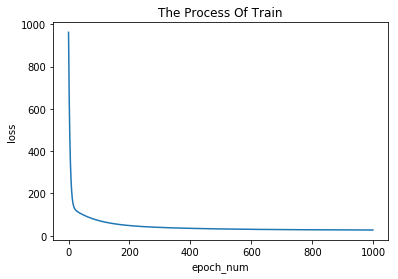

In [6]:
import numpy as np
import matplotlib.pyplot as plt

#数据导入以及处理
def deal_data():
    #读取文件数据，此时数据形状是(7084,)，即所有数据在一行中
    housingdata = np.fromfile('./housing.data',sep=' ')

    #修改数据格式，将每一条房屋数据放在一行中。
    housingdata = np.array(housingdata).reshape((-1,14))#此时数据形状为(506,14)

    #对数据的前13个属性进行归一化操作，有助于提高模型精准度，这里使用max-min归一化方式。公式为(x-min)/(max-min)
    for i in range(13):
        Max =  np.max(housingdata[:,i])
        Min = np.min(housingdata[:,i])
        housingdata[:,i]=(housingdata[:,i]-Min)/(Max-Min)

    #依据2-8原则，80%的数据作为训练数据，20%数据作为测试数据；此时训练数据是405条，测试数据是101条
    Splitdata = round(len(housingdata)*0.8)
    Train = housingdata[:Splitdata]#训练数据集
    Test = housingdata[Splitdata:]#测试数据集
    return Train,Test

#模型设计以及配置
#首先确定有13个权值参数w，并随机初始化
class Model_Config(object):
    def __init__(self,firstnetnum,secondnetnum):
        np.random.seed(1)
        self.w0 = np.random.randn(firstnetnum*secondnetnum,1).reshape(firstnetnum,secondnetnum)
        self.w1 = np.random.randn(secondnetnum,1)
        self.b0 = np.random.randn(firstnetnum,1).reshape(1,firstnetnum)
        self.b1 = np.random.randn(1,1)
     #计算预测值
    def forward(self,x):
        hidden1 = np.dot(x,self.w0)+self.b0
        y = np.dot(hidden1,self.w1)+self.b1
        return hidden1,y
    #设置损失函数,这里使用差平方损失函数计算方式
    def loss(self,z,y):
        error = z-y
        cost = error*error
        avg_cost = np.mean(cost)
        return avg_cost
    #计算梯度
    def back(self,x,y):
        hidden1,z = self.forward(x)
        #hidden层的梯度
        gradient_w1 = (z-y)*hidden1
        gradient_w1 = np.mean(gradient_w1,axis=0)#这里注意，axis=0必须写上，否则默认将这个数组变成一维的求平均
        gradient_w1 = gradient_w1[:,np.newaxis]#
        gradient_b1 = (z-y)
        gradient_b1 = np.mean(gradient_b1)
        gradient_w0 = np.zeros(shape=(13,13))
        for i in range(len(x)):
            data = x[i,:]
            data = data[:,np.newaxis]
            # print("data.shape",data.shape)
            w1 = self.w1.reshape(1,13)
            # print("self.w1.shape",w1.shape)
            gradient_w01 = (z-y)[i]*np.dot(data,w1)
            # print("gradient_w01.shape:",gradient_w01.shape)
            gradient_w0+=gradient_w01
        gradient_w0 = gradient_w0/len(x)
        w2 = self.w1.reshape(1,13)
        gradient_b0 =np.mean((z-y)*w2,axis=0)

        return gradient_w1,gradient_b1,gradient_w0,gradient_b0
        #输入层的梯度
        #(z-y)x*self.w1
        # gradient_w0 = np.zeros(shape=(13,13))
        # gradient_w01 = gradient_w1.reshape(1,13)
        # for i in range(13):
        #     data = x[:,i]
        #     data = data[:,np.newaxis]
        #     gradient = data*gradient_w01
        #     gradient = np.mean(gradient,axis=0)
        #     gradient_w0[i,:] = gradient
        # gradient_b0 = gradient_b1*self.b0
        # return gradient_w1,gradient_b1,gradient_w0,gradient_b0

    #使用梯度更新权值参数w
    def update(self,gradient_w1,gradient_b1,gradient_w0,gradient_b0,learning_rate):
        self.w1 = self.w1-learning_rate*gradient_w1
        self.b1 = self.b1-learning_rate*gradient_b1
        self.w0 = self.w0-learning_rate*gradient_w0
        self.b0 = self.b0-learning_rate*gradient_b0

    #开始训练
    def train(self,epoch_num,x,y,learning_rate):
        #循环迭代
        losses=[]
        for i in range(epoch_num):
            _,z = self.forward(x)
            avg_loss = self.loss(z,y)
            gradient_w1,gradient_b1,gradient_w0,gradient_b0 = self.back(x,y)
            self.update(gradient_w1,gradient_b1,gradient_w0,gradient_b0,learning_rate)
            losses.append(avg_loss)
            #每进行20此迭代，显示一下当前的损失值
            if(i%20==0):
                print("iter:{},loss:{}".format(i,avg_loss))

        return losses
def showpeocess(loss,epoch_num):
    plt.title("The Process Of Train")
    plt.plot([i for i in range(epoch_num)],loss)
    plt.xlabel("epoch_num")
    plt.ylabel("loss")
    plt.show()
if __name__ == '__main__':
    Train,Test = deal_data()
    np.random.shuffle(Train)
    #只获取前13个属性的数据
    x = Train[:,:-1]
    y = Train[:,-1:]
    epoch_num = 1000#设置迭代次数
    Model = Model_Config(13,13)
    losses = Model.train(epoch_num=epoch_num,x=x,y=y,learning_rate=0.001)
    showpeocess(loss=losses,epoch_num=epoch_num)


请点击[此处](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576)查看本环境基本用法.  <br>
Please click [here ](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576) for more detailed instructions. 